In [1]:
import yaml
import pathlib
import pickle as pk
from copy import deepcopy

import torch
import numpy as np
import seaborn as sns
import pandas as pd
import scipy.io as sio
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import umap
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.dummy import DummyClassifier

import utils
from data import MET_Data
from cplAE_MET.models.model_classes import MultiModal
from pca_cca import PCA_CCA, CCA_extended

In [2]:
met_data = sio.loadmat("../data/raw/MET_M120x4_50k_4Apr23.mat")
dest_name = "../data/raw/MET_M120x4_50k_4Apr23_PCA.mat"

In [3]:
X_raw = met_data["M_dat"]
X_flat = X_raw.reshape([X_raw.shape[0], -1])
X = X_flat[~np.isnan(X_flat).any(1)]
X_img = X_raw[~np.isnan(X_flat).any(1)]

In [4]:
pca = PCA().fit(X)

In [5]:
pca.explained_variance_[:30]

array([238.45192602, 205.73503199, 133.2169229 ,  87.81301684,
        76.45747027,  64.19640345,  49.22252175,  40.8984302 ,
        32.39007202,  27.34663408,  22.53659559,  18.95338982,
        16.43720989,  15.14639919,  13.37616068,  12.32610419,
        11.87707605,  11.43153007,  10.85703151,  10.07112978,
         9.53828513,   8.99565786,   8.73282858,   8.24174319,
         8.07991269,   7.3787204 ,   6.95770448,   6.76880828,
         6.27961599,   6.13819296])

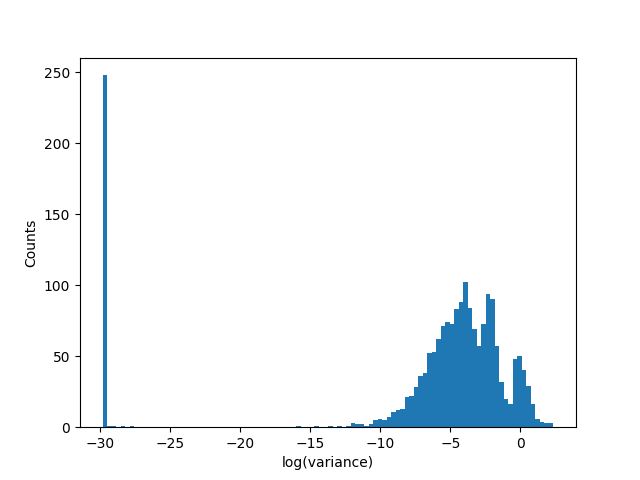

In [29]:
%matplotlib widget
(fig, ax) = plt.subplots(1, 1)
ax.hist(np.log10(pca.explained_variance_), 100)
ax.set_xlabel("log(variance)")
ax.set_ylabel("Counts")
plt.show()

/var/folders/l8/m2glkk_557l1j7xyp1qbh99m0000gp/T/ipykernel_27078/2935748899.py:2: RuntimeWarning: invalid value encountered in log10
  ax.plot(np.log10(1 - np.cumsum(pca.explained_variance_ratio_)), np.log10(pca.explained_variance_))


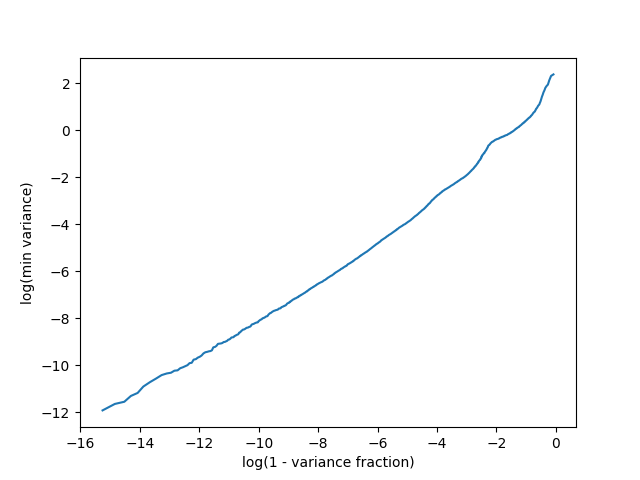

In [30]:
(fig, ax) = plt.subplots(1, 1)
ax.plot(np.log10(1 - np.cumsum(pca.explained_variance_ratio_)), np.log10(pca.explained_variance_))
ax.set_xlabel("log(1 - variance fraction)")
ax.set_ylabel("log(min variance)")
plt.show()

In [8]:
# var_threshold = 1e-3
# thresh_mask = pca.explained_variance_ > var_threshold
# scores = (X_flat - pca.mean_) @ pca.components_[thresh_mask].T
# print(f"Threshold: {var_threshold} | Num components: {components.shape[0]} | Variance frac: {pca.explained_variance_ratio_[thresh_mask].sum():.4f}")

In [21]:
scores = (X_flat - pca.mean_) @ pca.components_.T
matlab = deepcopy(met_data)
matlab["M_dat"] = scores
matlab["PCA_vars"] = pca.explained_variance_
sio.savemat(dest_name, matlab)

/var/folders/l8/m2glkk_557l1j7xyp1qbh99m0000gp/T/ipykernel_27078/2976416842.py:1: RuntimeWarning: divide by zero encountered in log10
  x = np.log10(X_img.flatten())


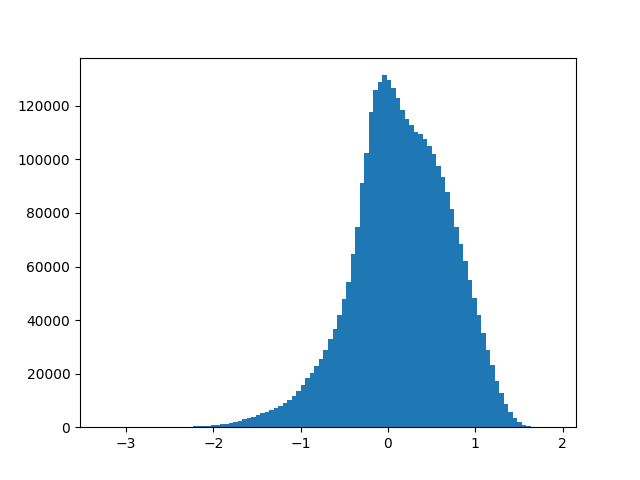

In [31]:
x = np.log10(X_img.flatten())
x = x[~np.isinf(x)]
(fig, ax) = plt.subplots(1, 1)
ax.hist(x, 100)
plt.show()

/var/folders/l8/m2glkk_557l1j7xyp1qbh99m0000gp/T/ipykernel_27078/398759377.py:1: RuntimeWarning: divide by zero encountered in log10
  x = np.log10(abs(scores.flatten()))


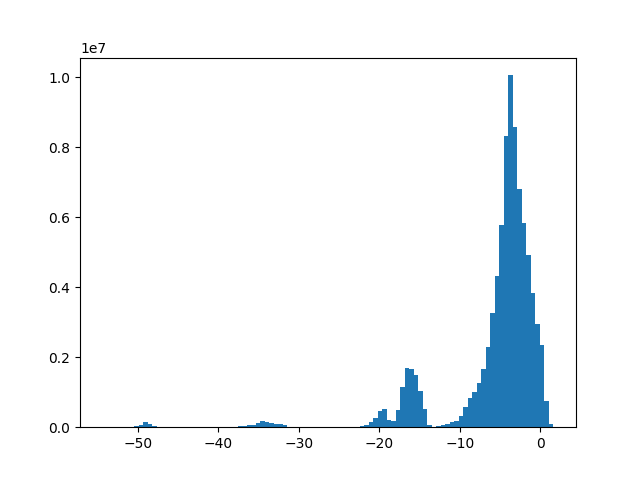

In [32]:
x = np.log10(abs(scores.flatten()))
x = x[~np.isinf(x)]
(fig, ax) = plt.subplots(1, 1)
ax.hist(x, 100)
plt.show()

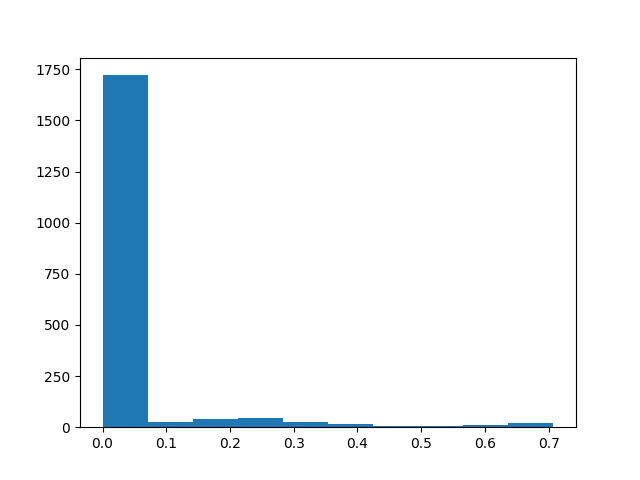

In [33]:
(fig, ax) = plt.subplots(1, 1)
ax.hist(np.count_nonzero(X_img, 0).flatten() / X_img.shape[0])
plt.show()

In [25]:
(non_zero, freq) = np.unique(np.count_nonzero(X, 0), return_counts = True)

In [26]:
non_zero[:10]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [27]:
freq[:10]/freq.sum()

array([0.06666667, 0.05572917, 0.02239583, 0.01510417, 0.01197917,
       0.0109375 , 0.0078125 , 0.00729167, 0.00833333, 0.01145833])

/var/folders/l8/m2glkk_557l1j7xyp1qbh99m0000gp/T/ipykernel_27078/3950642069.py:2: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(non_zero / X.shape[0]), np.cumsum(freq)/freq.sum())


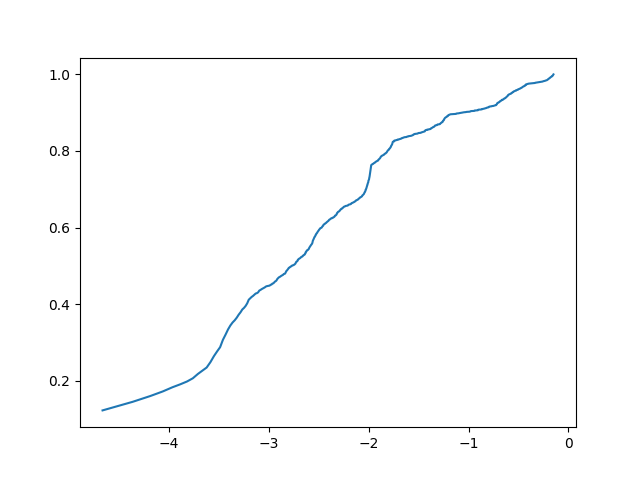

In [34]:
(fig, ax) = plt.subplots(1, 1)
ax.plot(np.log10(non_zero / X.shape[0]), np.cumsum(freq)/freq.sum())
plt.show()

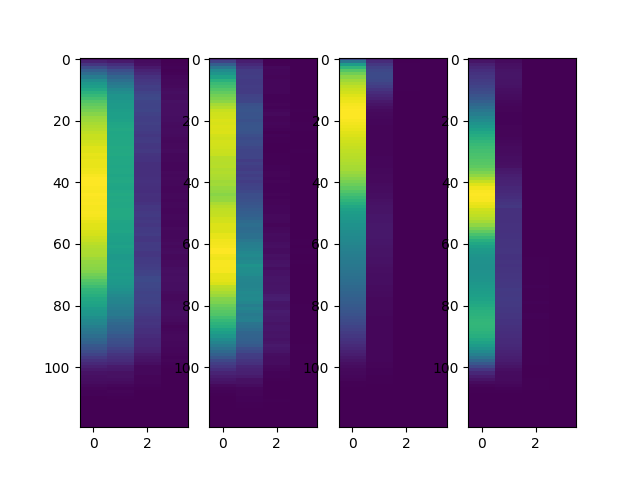

In [35]:
count_img = np.count_nonzero(X, 0).reshape(120, 4, 4)
(fig, axes) = plt.subplots(1, 4)
for (ax, proc) in zip(axes, np.moveaxis(count_img, 2, 0)):
    ax.imshow(proc / X.shape[0], aspect = "auto", interpolation = "None")
plt.show()

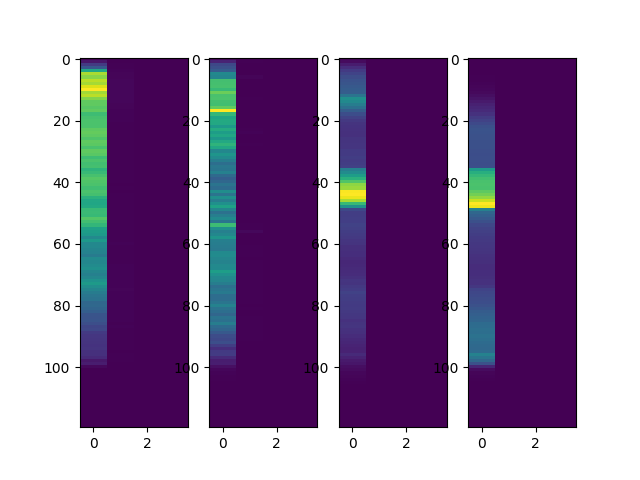

In [37]:
var_img = np.var(X_img, 0)
(fig, axes) = plt.subplots(1, 4)
for (ax, proc) in zip(axes, np.moveaxis(var_img, 2, 0)):
    ax.imshow(proc, aspect = "auto", interpolation = "None")
plt.show()

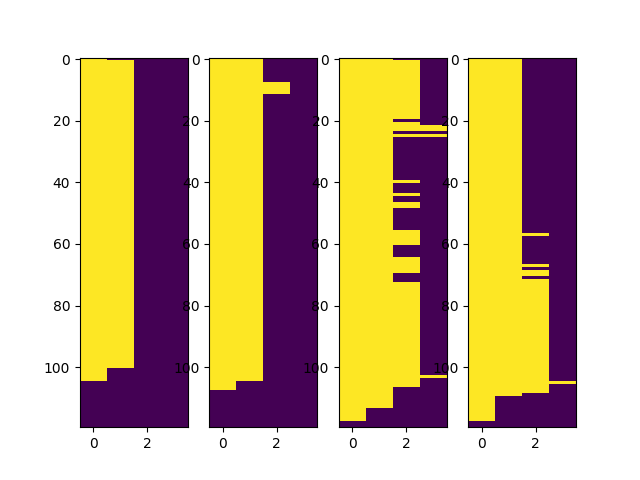

In [40]:
var_mask = (np.var(X_img, 0) > 1e-4).astype("float")
(fig, axes) = plt.subplots(1, 4)
for (ax, proc) in zip(axes, np.moveaxis(var_mask, 2, 0)):
    ax.imshow(proc, aspect = "auto", interpolation = "None")
plt.show()